In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
#ABOVE added to use development version of cana
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
# from dynamics_canalization_map import draw_dynamics_canalization_map_graphviz # if required, can add this from Parmer's CANA branch -- REDUNDANT CODE -- REPLACE WITH LINE BELOW
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz # UPDATED METHOD

import matplotlib as mpl
import matplotlib.style
#mpl.style.use('classic')
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST, LEUKEMIA, BREAST_CANCER
from itertools import combinations
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess
#
import json
import ast
#BELOW added for graphviz to work on windows
# os.environ["PATH"] += os.pathsep + "C:/Anaconda/pkgs/graphviz-2.38.0-4/Library/bin/"
# os.environ["PATH"] += os.pathsep + 'C:/Anaconda/Library/bin/graphviz/'

import networkx as nx
from cana.boolean_network import BooleanNetwork # required to load the toy network

In [3]:
# Is this function still needed? What does it do?
def multi_column_display(objs, titles=['',''], cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'><h3>{{title}}</h3>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=obj,title=title) for obj,title in zip(objs,titles) ]
    cells += (cols - (len(objs)%cols)) * [html_cell.format(content="",title="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [4]:
# # Load biological networks stored in cana
# N = DROSOPHILA()
# N3=LEUKEMIA()
# N4=BREAST_CANCER()
# NT = THALIANA()
# NY = BUDDING_YEAST()

#### Check out my toy network

In [182]:
N = BooleanNetwork.from_file("./test-BN.txt", keep_constants=True, name = 'example')

In [6]:
N.name

'example'

In [183]:
Nsg = N.structural_graph()

In [184]:
#Node Position for each one of the models
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
print(nodes)
att = {}

if N.name == 'Arabidopsis Thaliana':
    foldername = 'thaliana'
    
    # Calculates Node position in a circle. Used to plot nodes always in the same position.
    for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
        r = 150
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['UFO','LUG','CLF'], [(200.,140.),(240.,50.),(240.,-50.)]):
        att[name] = {'x':x,'y':y}

elif N.name == 'Drosophila Melanogaster':
    foldername = 'drosophila'
    
    x,y = np.linspace(0,500,8,dtype=int), np.linspace(500,0,8,dtype=int)
    att['nWG']    = {'x':x[5],'y':y[0],'color':'orangered'} #'fillcolor':'#4f6fb0'
    att['SLP']    = {'x':x[7],'y':y[1],'color':'orangered','fillcolor':'grey70'} #'fillcolor':'#4f6fb0'
    att['en']     = {'x':x[5],'y':y[1]}
    att['EN']     = {'x':x[5],'y':y[2]}
    att['nhhnHH'] = {'x':x[1],'y':y[4]}
    att['ci']     = {'x':x[4],'y':y[3],'fillcolor':'grey70'}
    att['PTC']    = {'x':x[2],'y':y[4],'fillcolor':'grey70'}
    att['nhhnHH'] = {'x':x[2],'y':y[2],'color':'orangered'} #'fillcolor':'#4f6fb0'
    att['CI']     = {'x':x[4],'y':y[4],'fillcolor':'grey70'}
    att['PH']     = {'x':x[0],'y':y[5],'fillcolor':'grey70'}
    att['SMO']    = {'x':x[1],'y':y[5]}
    att['CIA']    = {'x':x[3],'y':y[5],'fillcolor':'grey70'}
    att['CIR']    = {'x':x[4],'y':y[5],'fillcolor':'grey70'}
    att['ptc']    = {'x':x[3],'y':y[6],'fillcolor':'grey70'}
    att['wg']     = {'x':x[4],'y':y[6],'fillcolor':'grey70'}
    att['hh']     = {'x':x[6],'y':y[6]}
    att['WG']     = {'x':x[4],'y':y[7],'fillcolor':'grey70'}
    att['HH']     = {'x':x[6],'y':y[7]}

elif N.name == 'Budding Yeast Cell Cycle':
    foldername = 'yeast'
    
    # Calculates Node position in a circle.
    for deg,name in zip( np.linspace(0,360,10), ['Cln3','MBF','Clb5,6','Mcm1/SFF','Swi5','Cdc20/14','Cdh1','Cln1,2','SBF']):
        r = 190
        deg += 90
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['CellSize','Sic1','Clb1,2'], [(0.,280.),(0.,100.),(0.,-50.)]):
        att[name] = {'x':x,'y':y}

elif N.name == 'Binary Tree':
    x,y = np.linspace(0,500,15,dtype=int), np.linspace(300,0,4,dtype=int)
    att['SLP']    = {'x':x[7],'y':y[0]}
    att['SLP_LOW']    = {'x':x[3],'y':y[1]}
    att['SLP_HIGH']     = {'x':x[11],'y':y[1]}
    att['SLP_Q1']     = {'x':x[1],'y':y[2]}
    att['SLP_Q2'] = {'x':x[5],'y':y[2]}
    att['SLP_Q3']     = {'x':x[9],'y':y[2]}
    att['SLP_Q4']    = {'x':x[13],'y':y[2]}
    att['SLP_0'] = {'x':x[0],'y':y[3]}
    att['SLP_1']     = {'x':x[2],'y':y[3]}
    att['SLP_2']     = {'x':x[4],'y':y[3]}
    att['SLP_3']    = {'x':x[6],'y':y[3]}
    att['SLP_4']    = {'x':x[8],'y':y[3]}
    att['SLP_5']    = {'x':x[10],'y':y[3]}
    att['SLP_6']    = {'x':x[12],'y':y[3]}
    att['SLP_7']     = {'x':x[14],'y':y[3]}
    
elif N.name == 'HER3 Tree':
    x,y = np.linspace(0,500,7,dtype=int), np.linspace(500,0,3,dtype=int)
    att['HER3_012']    = {'x':x[3],'y':y[0],'fillcolor':'#4f6fb0'}
    att['HER3_01']    = {'x':x[1],'y':y[1],'fillcolor':'#4f6fb0'}
    att['HER3_2']     = {'x':x[5],'y':y[1],'fillcolor':'#4f6fb0'}
    att['HER3_0']     = {'x':x[0],'y':y[2],'fillcolor':'#4f6fb0'}
    att['HER3_1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0'}
    
        
else:
    foldername = 'networks'

    # Calculates Node position in a circle for any network
    for deg,name in zip( np.linspace(0,360,len(nodes.keys())), nodes.keys()):
        r = 150
        #deg += 90
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        if name=='X':
            att[name] = {'x':x,'y':y,'fillcolor':'#4f6fb0'}
        else:
            att[name] = {'x':x,'y':y,}
    
    #rectangular alternate    
    #x,y = np.linspace(0,500,10,dtype=int), np.linspace(500,0,10,dtype=int)
    #for i,node in enumerate(nodes):
    #    att[node] = {'x':x[i/10],'y':y[i%10]}

{'i1': 0, 'i2': 1, 'g1': 2, 'g2': 3, 'P1': 4, 'P2': 5}


[(0, {'label': 'i1'}), (1, {'label': 'i2'}), (2, {'label': 'g1'}), (3, {'label': 'g2'}), (4, {'label': 'P1'}), (5, {'label': 'P2'})]
Nodes: 6 | Edges: 8


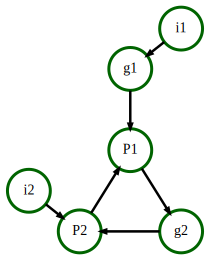

In [9]:
from cana.boolean_network import BooleanNetwork 
#interaction examples
NG = BooleanNetwork.from_file("./test-BN.txt", keep_constants=True, name = 'example')
Nsg = NG.structural_graph()
print(Nsg.nodes(data=True))
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
att = {}

if 'Interactions' in Nsg.name:
    x,y = np.linspace(0,500,6,dtype=int), np.linspace(500,0,3,dtype=int)
    att['A']    = {'x':x[0],'y':y[0],'fillcolor':'#4f6fb0','label':'A','shape':'oval'}
    att['B']    = {'x':x[1],'y':y[0],'fillcolor':'#4f6fb0','label':'B','shape':'oval'}
    att['C']     = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'C','shape':'oval'}
    att['B0']     = {'x':x[0],'y':y[1],'fillcolor':'#4f6fb0','label':'B-0','shape':'oval'}
    att['B1'] = {'x':x[1],'y':y[0],'fillcolor':'#4f6fb0','label':'B-1','shape':'oval'}
    att['D'] = {'x':x[0],'y':y[2],'fillcolor':'#4f6fb0','label':'D','shape':'oval'}
    att['E'] = {'x':x[1],'y':y[2],'fillcolor':'#4f6fb0','label':'E','shape':'oval'}
    att['T3'] = {'x':x[2],'y':y[1],'fillcolor':'#4f6fb0','label':'tau=3','shape':'oval'}
    att['F'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'F','shape':'oval'}
    att['G'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'G','shape':'oval'}
    att['T2'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['H'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'H','shape':'oval'}
    att['C0'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'C-0','shape':'oval'}
    att['C1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'C-1','shape':'oval'}
    att['T2_1'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['I'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'I','shape':'oval'}
    att['J'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'J','shape':'oval'}
    att['K'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'K','shape':'oval'}
    att['T2_2'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'tau=2','shape':'oval'}
    att['L'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'L','shape':'oval'}
    att['M'] = {'x':x[4],'y':y[2],'fillcolor':'#4f6fb0','label':'M','shape':'oval'}
    
elif 'Motif' in Nsg.name: #toy motif
    x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,5,dtype=int)
    att['X1']    = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'X1','shape':'circle'}
    att['X2']    = {'x':x[2],'y':y[2],'fillcolor':'#4f6fb0','label':'X2','shape':'circle'}
    att['X3']    = {'x':x[4],'y':y[4],'fillcolor':'#4f6fb0','label':'X3','shape':'circle'}
    att['X4']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0','label':'X4','shape':'circle'}

elif 'Module' in Nsg.name: #module example
    x,y = np.linspace(0,500,3,dtype=int), np.linspace(500,0,4,dtype=int)
    att['i1']    = {'x':x[0],'y':y[0],'fillcolor':'#4f6fb0','label':'i1','shape':'circle'}
    att['i2']    = {'x':x[2],'y':y[0],'fillcolor':'#4f6fb0','label':'i2','shape':'circle'}
    att['x']    = {'x':x[1],'y':y[1],'fillcolor':'#4f6fb0','label':'X','shape':'circle'}
    att['c']    = {'x':x[1],'y':y[2],'fillcolor':'#4f6fb0','label':'d','shape':'circle'}
    att['d']    = {'x':x[1],'y':y[3],'fillcolor':'#4f6fb0','label':'e','shape':'circle'}
    
elif 'example' in Nsg.name: #GRN example
    x,y = np.linspace(0,500,5,dtype=int), np.linspace(500,0,6,dtype=int)
    att['i1']    = {'x':x[3],'y':y[0],'fillcolor':'#4f6fb0','label':'i1','shape':'circle'}
    att['i2']    = {'x':x[0],'y':y[4],'fillcolor':'#4f6fb0','label':'i2','shape':'circle'}
    att['g1']    = {'x':x[2],'y':y[1],'fillcolor':'#4f6fb0','label':'g1','shape':'circle'}
    att['P1']    = {'x':x[2],'y':y[3],'fillcolor':'#4f6fb0','label':'P1','shape':'circle'}
    att['g2']    = {'x':x[3],'y':y[5],'fillcolor':'#4f6fb0','label':'g2','shape':'circle'}
    att['P2']    = {'x':x[1],'y':y[5],'fillcolor':'#4f6fb0','label':'P2','shape':'circle'}

#draw interaction
if 'Interactions' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='dot')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.5', ranksep='0.25', nodesep='0.95', 
           rankdir='LR') #left right for interactions
    S.attr('node', shape='oval', fixedsize='true', width='.80', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
           fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')
    keepers=['A','B1','B0','C','K','T2_2','L','M']
elif 'Motif' in Nsg.name or 'Module' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='neato')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.5', ranksep='5', nodesep='50',)
    #S.attr('node', fixedsize='true', width='.60', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
    #       fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='0.5', color='#545454')
    keepers=[Nsg.node[n]['label'] for n in Nsg.nodes()]
    keepers=['i1','i2','x']
    
elif 'example' in Nsg.name:
    S = graphviz.Digraph(name='Structural Graph', engine='neato')
    S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false',pad='0.1', ranksep='5', nodesep='50',)
    S.attr('node', fixedsize='true', width='.60')#, color='gray', style='filled', fillcolor='#515660', penwidth='3', 
    #       fontname='Helvetica', fontcolor='ghostwhite',fontsize='12')
    S.attr('edge', arrowhead='normal', arrowsize='0.5', color='#545454')
    keepers=[Nsg.nodes[n]['label'] for n in Nsg.nodes()]
    

for node,d in Nsg.nodes(data=True):

    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
        fillcolor = '#515660'
    if d['label'] in keepers:
        S.node(name=str(node), label=natt['label'], pos=xy, fillcolor=fillcolor,shape=natt['shape'], color='darkgreen', penwidth='3')

#alternate
#for node,d in Nsg.nodes(data=True):
#    natt = att[d['label']]
#    S.node(name=str(nid), **natt)    

max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    if s==t: continue #include this line to get rid of self-loops
    #print Nsg.node[s]['label']
        
    if (Nsg.nodes[s]['label'] not in keepers) or (Nsg.nodes[t]['label'] not in keepers): 
        continue #include this line to view only interactions we want
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    if 'example' in Nsg.name and s==5 and t==3:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black', arrowhead='tee', arrowsize='1.0')
    else:
        S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, minlen='2', color='black')
print ('Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) ))
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})

# Export
#S._format = 'pdf'
#efile = u"%s/../experiments/2017 - BioModels/%s/graphs/motif_structure" % (os.getcwd(),foldername)
#S.render(efile, cleanup=True)
#subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

Simplified DCM


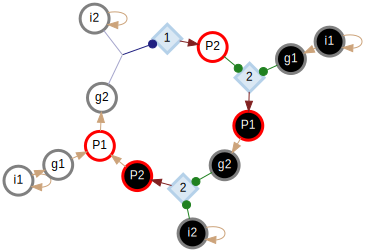

Black units -> ON nodes 
White units -> OFF nodes


In [185]:
# Draw the DCM
DCM = N.dynamics_canalization_map(output=None, simplify=True) # simplifly = True (default) removes most of threshold=1 nodes and replaces them with fusion nodes
D = draw_canalizing_map_graphviz(DCM, overlap='true')
print("Simplified DCM")
display(D)
print("Black units -> ON nodes \nWhite units -> OFF nodes")

Non-simplified DCM


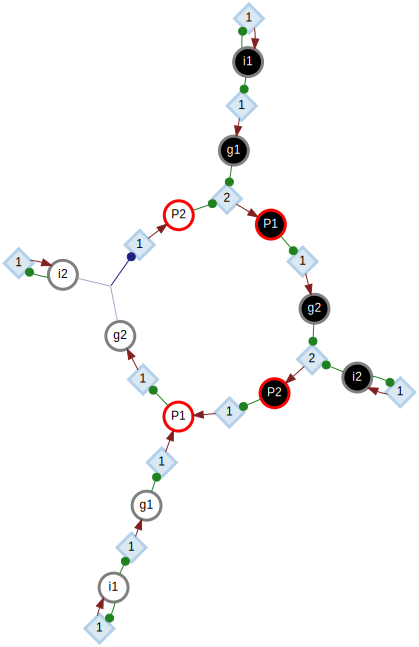

In [186]:
# to verify usage of 'simplify=True/False' in the dynamics_canalization_map function, plot the DCM with simplify=False
DCM2 = N.dynamics_canalization_map(output=None, simplify=False) 
D2 = draw_canalizing_map_graphviz(DCM2, overlap='true')
print("Non-simplified DCM")
display(D2)

In [12]:
#convert attractors from the STG of the network to a dictionary representation where each attractor is {variable names:ON or OFF}
def attractors_to_dict(n, type=1):
    """
    Here, n is a cana BooleanNetwork object
    
    """

    attractor_dict={}
    attractors=n.attractors()
    for attractor in attractors:
        label=n._stg.nodes[attractor[0]]['label'] #only pay attention to the first state for now # MODIFIED CODE: changed "node" to "nodes"
        #for i,var in enumerate(N.nodes): print i,type(var.name),type(label)
        #attractor_dict[label]={var.name:label[i] for i,var in enumerate(N.nodes)}
        # attractor_dict[label]={var.name+'-'+label[i] for i,var in enumerate(n.nodes)} #alternative, assumes labeling standard
        if type==1:
            attractor_dict[label]={'var-'+str(var.id)+'-out-'+label[i] for i,var in enumerate(n.nodes)} 

        else:
            # can use this now since code for name transformation is added in BFS_threshold() method
            attractor_dict[label]={var.name+'-'+label[i] for i,var in enumerate(n.nodes)} #alternative, assumes labeling standard

    return attractor_dict

In [13]:
import random
#threshold network conversion
def create_threshold_network(n):
    """ Create a digraph compatible with threshold network manipulation
    Expects a DCM-like digraph as input, returns a threshold-like digraph where every node is a literal and/or threshold node
    
    Valid nodes include these properties: label, threshold (tau), type, time delay, variable, state
    Valid edges include these properties: type 
    
    NOTE: the DCM originally has a separate fusion node for each literal enput of the same state involved in the same symmetry group
    However, this means that the same enput can activate multiple edges rather than just one
    As a solution, each group of fusion nodes that are associated with the same state and the same symmetry group are replaced
    by one threshold node with tau=n, where n is the number of fusion nodes that were combined into that threshold node """
    
    n=n.copy() #don't change the original graph
    
    #check for similar fusion nodes
    fusion_nodes=[name for name in n.nodes() if n.nodes[name]['type']=='fusion']
    groups={} #each group will share the same predecessors and successors
    i=0
    for f in fusion_nodes:
        predecessors=set(n.predecessors(f))
        successors=set(n[f])
        found=False
        for key in groups:
            if groups[key]['predecessors']==predecessors and groups[key]['successors']==successors: #we have a match
                groups[key]['nodes'].append(f)
                found=True
                break
        if not found: #make a new group
            groups[i]={'predecessors':predecessors, 'successors':successors, 'nodes':[f]}
            i+=1
    #delete fusion nodes and replace with new threshold nodes
    for t in groups: #add new threshold nodes
        name="F-T"+str(t)
        tau=len(groups[t]['nodes'])
        group=n.nodes[random.choice(tuple(groups[t]['successors']))]['group'] #take group attribute of random successor, necessary for visualization

        # n.add_node(name,{'label':str(tau),'type':'threshold','tau':tau,'group':group}) # DOES NOT WORK  
        # node attributes must be added manually -- MODIFIED CODE
        n.add_node(name)
        n.nodes[name]['label']=str(tau)
        n.nodes[name]['type']='threshold'
        n.nodes[name]['tau']=tau
        n.nodes[name]['group']=group


        #adjust successor node thresholds; add 1 for new threshold node and then subtract for each fusion node deleted
        for successor in groups[t]['successors']: #there should only be one
            n.add_edge(name,successor)
            n.nodes[successor]['tau'] += 1 - tau
            n.nodes[successor]['label'] = str(n.nodes[successor]['tau'])
        #add new edges to threshold nodes from predecessors
        for predecessor in groups[t]['predecessors']:
            n.add_edge(predecessor,name)
        
    #delete fusion nodes and adjacent edges
    for f in fusion_nodes:
        n.remove_node(f)
    #print groups
    
    for name in n.nodes():
        
        if 'label' not in n.nodes[name]:
            n.nodes[name]['label']='unknown'
            
        if 'type' not in n.nodes[name]:
            n.nodes[name]['type']='unknown'
            
        if 'tau' not in n.nodes[name]:
            if n.nodes[name]['type']=='threshold':
                n.nodes[name]['tau']=1
            else:
                n.nodes[name]['tau']=0
                
        if 'delay' not in n.nodes[name]:
            if n.nodes[name]['type']=='threshold':
                n.nodes[name]['delay']=0
            else:
                n.nodes[name]['delay']=1
        
        #assume variable name comes from the label
        if 'variable' not in n.nodes[name] and n.nodes[name]['type']=='variable':
            n.nodes[name]['variable']=n.nodes[name]['label'] # assign name of node to variable property
            
        #assume states are only positive integers
        if 'state' not in n.nodes[name] and n.nodes[name]['type']=='variable':
            state_str=name.replace(n.nodes[name]['variable'],"") #remove variable name
            state_str=''.join([s for s in state_str if s.isdigit()]) #concatenate string from all integers left in name (in case of double-digit states)
            n.nodes[name]['state']=int(state_str)
                
        #print name,n.node[name]
        
    return n

#create_threshold_network(DCM)

In [187]:
threshold_DCM = create_threshold_network(DCM)

In [188]:
print("Original DCM:")
for name in DCM.nodes():
    print(name, DCM.nodes[name])

print("\nThreshold DCM:")
for name in threshold_DCM.nodes():
    print(name, threshold_DCM.nodes[name])

Original DCM:
var-0-out-0 {'label': 'i1', 'type': 'variable', 'mode': 'input', 'value': 0, 'constant': False, 'group': 2}
var-0-out-1 {'label': 'i1', 'type': 'variable', 'mode': 'input', 'value': 1, 'constant': False, 'group': 2}
var-1-out-0 {'label': 'i2', 'type': 'variable', 'mode': 'input', 'value': 0, 'constant': False, 'group': 5}
var-1-out-1 {'label': 'i2', 'type': 'variable', 'mode': 'input', 'value': 1, 'constant': False, 'group': 5}
var-2-out-0 {'label': 'g1', 'type': 'variable', 'mode': 'input', 'value': 0, 'constant': False, 'group': 4}
var-2-out-1 {'label': 'g1', 'type': 'variable', 'mode': 'input', 'value': 1, 'constant': False, 'group': 4}
var-3-out-0 {'label': 'g2', 'type': 'variable', 'mode': 'input', 'value': 0, 'constant': False, 'group': 5}
var-3-out-1 {'label': 'g2', 'type': 'variable', 'mode': 'input', 'value': 1, 'constant': False, 'group': 5}
var-4-out-0 {'label': 'P1', 'type': 'variable', 'mode': 'output', 'value': 0, 'group': 4, 'constant': False}
var-4-out-1 {

In [16]:
threshold_DCM.nodes['var-2-out-1']

{'label': 'g1',
 'type': 'variable',
 'mode': 'input',
 'value': 1,
 'constant': False,
 'group': 4,
 'tau': 0,
 'delay': 1,
 'variable': 'g1',
 'state': 21}

It seems that the 'state' of each node is of the format {node_id}{state} -- therefore, if node i2 (node_id=2) is in state 0, this is written as state=20.

In [17]:
threshold_DCM=create_threshold_network(DCM)

In [18]:
threshold_DCM.nodes['var-1-out-1']

{'label': 'i2',
 'type': 'variable',
 'mode': 'input',
 'value': 1,
 'constant': False,
 'group': 5,
 'tau': 0,
 'delay': 1,
 'variable': 'i2',
 'state': 11}

In [ ]:
# for node in threshold_DCM.nodes:
#     print(node)

threshold_DCM.nodes['var-5-out-0']

{'label': 'P2',
 'type': 'variable',
 'mode': 'output',
 'value': 0,
 'group': 5,
 'constant': False,
 'tau': 0,
 'delay': 1,
 'variable': 'P2',
 'state': 50}

In [19]:
mod_units = []
for name in ['i1-1', 'P1-0', 'g2-1']:
    print(name.split(sep="-"))
    label, state = name.split(sep="-")
    
    for node in threshold_DCM.nodes:
        # print(node)
        if threshold_DCM.nodes[node]['type'] == 'variable':
            if threshold_DCM.nodes[node]['label'] == label and str(threshold_DCM.nodes[node]['value']) == state:
                mod_units.append(node)
                break

mod_units


['i1', '1']
['P1', '0']
['g2', '1']


['var-0-out-1', 'var-4-out-0', 'var-3-out-1']

In [20]:
# alternate 1
mod_units = []
for name in ['i1-1', 'P1-0', 'g2-1']:
    label, state = name.split("-")

    for node, attrs in threshold_DCM.nodes(data=True):
        if (attrs.get("type") == "variable"
            and attrs.get("label") == label
            and str(attrs.get("value")) == state):
            mod_units.append(node)
            break

mod_units

['var-0-out-1', 'var-4-out-0', 'var-3-out-1']

In [21]:
# alternate 2
mod_units = [
    node for name in [ 'i1-1', 'P2-0', 'g2-1', 'g1-0', 'i2-1']
    for node, attrs in threshold_DCM.nodes(data=True)
    if (attrs.get("type") == "variable"
        and attrs.get("label") == name.split("-")[0]
        and str(attrs.get("value")) == name.split("-")[1])
]

mod_units

['var-0-out-1', 'var-5-out-0', 'var-3-out-1', 'var-2-out-0', 'var-1-out-1']

In [22]:
# Build lookup dict: (label, value) -> node
lookup = {
    (attrs["label"], str(attrs["value"])): node
    for node, attrs in threshold_DCM.nodes(data=True)
    if attrs.get("type") == "variable"
}

print(lookup)

# Collect matching nodes
mod_units = [
    lookup[(label, state)]
    for label, state in (name.split("-") for name in ['i1-1', 'P2-0', 'g2-1', 'g1-0', 'i2-1'])
    if (label, state) in lookup
]
mod_units

{('i1', '0'): 'var-0-out-0', ('i1', '1'): 'var-0-out-1', ('i2', '0'): 'var-1-out-0', ('i2', '1'): 'var-1-out-1', ('g1', '0'): 'var-2-out-0', ('g1', '1'): 'var-2-out-1', ('g2', '0'): 'var-3-out-0', ('g2', '1'): 'var-3-out-1', ('P1', '0'): 'var-4-out-0', ('P1', '1'): 'var-4-out-1', ('P2', '1'): 'var-5-out-1', ('P2', '0'): 'var-5-out-0'}


['var-0-out-1', 'var-5-out-0', 'var-3-out-1', 'var-2-out-0', 'var-1-out-1']

In [23]:
string = 'T-0_wg-0'
string.split(sep="-")

['T', '0_wg', '0']

In [24]:
from collections import deque
#specialized BFS to work for threshold network
def BFS_threshold(n,seed,input_type='steady',time_limit=1,conversion=True, name_conversion=True):
    # BFS -> Breadth-First Search -- type of algorithm
    
    """ 
    n : DCM representation of a network
    
    -> Does specialized BFS on a threshold network n
    -> input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
       or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    -> seed may be a single node or a list of starting nodes

    -> not sure if input_type='pulse' logic works correctly
    
    Implementation based on BFS with a priority queue of times {t: q} 
    where t is the time when those nodes become active and q are the nodes active at that time step 
    
    Returns a dictionary of nodes visited at each time step
    
    NOTE: a threshold network is required, this will break if fusion nodes have not been removed
    Assume that a conversion is needed; will not run conversion if conversion argument set to False 
    
    NOTE: if run with input_type='steady', unfolding contains only the new states visited at that time step
    while all previous states visited are also considered active
    if run with input_type='pulse', unfolding contains EVERY node that is active at that time step, 
    even if it has been active before 
    
    NOTE: if run with input_type='steady', then ignore any node that is a different state of the starting seed;
    because we are pinning control of that variable, we need to remove all other possible variable states from the network """
    
    if conversion: #note conversion is slow due to a network deep copy 
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation") 
        
    # from this point onwards, n is a threshold network (modified representation)
        
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]

    # ***********************************************************************************************
    # convert seed names from i1-1, i2-0, etc to a version that is compatible with the DCM network -- var-0-out-1, var-1-out-0, etc -- REPORT THIS AS AN ISSUE IN THE CANA GITHUB
    # Build lookup dict: (label, value) -> node

    if name_conversion:
        lookup = {
            (attrs["label"], str(attrs["value"])): node
            for node, attrs in n.nodes(data=True)
            if attrs.get("type") == "variable"
        }

        # Collect matching nodes
        mod_units = [
            lookup[(label, state)]
            for label, state in (name.split("-") for name in seed)
            if (label, state) in lookup
        ]

        seed = mod_units
    
    # print(f"MODIFIED SEEDS: {seed}")

    # ***********************************************************************************************

    for node in seed:
        if node not in n.nodes():
            raise Exception('Seed not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':        
        # retrieve node names and states for each 'seed' node
        # here, n.nodes[x]['variable'] contains the actual name of the node: e.g. 'wg', 'i2', etc.
        # n.nodes[x]['state'] contains the state of that node depending on node-id: e.g. '21', '20' -- for state 1 and 0 of node_id=2 (here, 'i2')
        # use n.nodes[x]['value'] instead since it already has the actual binary state (0 or 1) for each variable node
        
        vals={n.nodes[x]['variable']:n.nodes[x]['value'] for x in seed if n.nodes[x]['type']=='variable'} 

        # seed nodes are specified with states, so we need to ensure that the initial nodes+states for these nodes in the network are not contradictory
        # if contradiction exists, store nodes in a set to be ignored during BFS
        contradictory_nodes={node for node in n if 
                        n.nodes[node]['type']=='variable' and n.nodes[node]['variable'] in vals and n.nodes[node]['value']!=vals[n.nodes[node]['variable']]}
    else:
        contradictory_nodes={}
        
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    #create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step=set(seed) #active nodes for this time step, will be different than visited if input_type='pulse'
    
    while time<=max(time_steps): #allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        #update counter
        old_length=len(visited)
        visited.update(active_step)

        if len(visited)==old_length: #increase counter if we have not added anything new
            counter+=1

        #print time,len(visited)
        #reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
        #print time,active_step
        
        if input_type=='pulse':
            thresholds={}
            active_step=set()
        
        #check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break 

        #run BFS
        while time_steps.get(time): 

            node=time_steps[time].popleft() # retrieve the next node to visit from the queue
            #add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node)
            
            #check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            for neighbor in n[node]:

                #ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                if neighbor in contradictory_nodes:
                    continue

                if neighbor not in active_step:
                    #check that neighbor passes the threshold test if it has a non-trivial threshold
                    if n.nodes[neighbor]['tau']>1:
                        # This implies that a threshold (>1) exists for this neighbour, and that the current (predecessor) 'node' has been activated. 
                        # Therefore, net score (of incoming) activated edge += 1 -- which is tracked by adding 'node' to list of active predecessors to this neighbor 
                        thresholds.setdefault(neighbor,set())
                        thresholds[neighbor].add(node)  #add node due to this incoming edge, ensures node can only contribute once

                    if neighbor not in thresholds or len(thresholds[neighbor])>=n.nodes[neighbor]['tau']:
                        #at this point we have passed the threshold, so insert neighbor at proper time slot t
                        t = time + n.nodes[neighbor]['delay']
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(neighbor) # at time_steps[t], neighbor will be visited
                        active_step.add(neighbor) 
                           
        #next iteration
        time+=1
    
    return unfolding

#print BFS_threshold(DCM,['nWG-1','SLP-0'],'steady',time_limit=1) #'SLP-1','CIR-0','CIA-1','SLP-0','nWG-1','en-1'
#print BFS_threshold(DM,['Six-1','Four-0','Two-0','Three-1'],'steady')

In [25]:
#grid representation of dynamic unfolding
#code from https://github.com/brahmcapoor/cellular-automata/blob/master/main.py
from matplotlib import colors

def visualize_unfolding(n,seed,node_set=None,node_ranges=None,input_type='steady',time_limit=1,conversion=True,figsize=(10,10),
                       interference=True,rotation=45,fontsize=16,fontweight=None,labels=True):

    """ Visualize one pathway by using a grid-like representation of node states 
    Can visualize using thresholded network or the original DCM 
    
    Expects a node_set of which nodes we want to display on the x-axis or else uses all variables by default 
    If interference is True, we assume a node's state during only one time step with pulse input
    If interference is False, we assume a node keeps its state until it is changed with pulse input 
    Rotation changes the rotation of the x-axis labels; for simplicity, fontsize and fontweight apply to both axes and the ylabel 
    Setting labels to False suppresses any axis labels from being shown """
    
    # TODO: allow for node ranges to be set to express full range of states (normalized to 0 to 1)
    
    if conversion:
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
            
    if not node_set: # use all variables from the network
        node_set={n.nodes[x]['variable'] for x in n if n.nodes[x]['type']=='variable'}
        
    # determine pathway -- get list of nodes visited in each time step <= time_limit or till no further nodes can be visited
    unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False) 
    
    xvalues=list(node_set) # get list of nodes
    time=max(unfolding) # gives the final time_step of pathway unfolding 
    grid=[[-1 for x in xvalues] for t in range(time+1)] #use -1 for wildcard value to accomodate multi-state nodes
    
    # visualize unfolding, assumes variable can only be in one state at one time step
    for t in range(time+1): # make sure to include time 0 and time t
        vals={n.nodes[x]['variable']:n.nodes[x]['state'] for x in unfolding[t] if n.nodes[x]['type']=='variable'} # ensuring node_type='variable' skips the threshold/fusion nodes
        
        # here, however, the node states are stored as {node_id}{node_state} which implies that all nodes have states >=10 (for node_id >= 1) -- can cause visualization issues
        # this can be resolved by modifying the last few lines in the create_threshold_network() method

        for i,x in enumerate(xvalues):
            if x in vals: 
                # if you want to use the below line instead, specify n.nodes[x]['value'] instead of 'state' to retrieve binary states
                # grid[t][i]=vals[x] # since states are not simply 1s or 0s, replace with line below ***************** 
                grid[t][i] = vals[x]%10

                #if this is steady_state, assume this condition holds for the rest of time (or if no interference is assumed)
                if input_type=='steady' or not interference:
                    for t2 in range(t+1,time+1):
                        grid[t2][i]=vals[x]%10 # added '%10' to bring state values back to 0 or 1 (by removing node_id)

    #print unfolding, grid 

    #TODO: create gradation for multi-state
    cmap = colors.ListedColormap(['grey', 'white', 'black'])
    bounds = [-1, 0, 1, 1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    fig = plt.figure(figsize=figsize)
    ax = plt.gca()

    ax.set_xticks(np.linspace(-0.5,len(node_set)-1.5,num=len(node_set))) #major ticks used for grid
    ax.set_xticks(np.linspace(0,len(node_set)-1,num=len(node_set)),minor=True) #minor ticks used for labeling
    ax.set_yticks(np.linspace(-0.5,time-0.5,num=time+1)) #major ticks used for grid
    ax.set_yticks(np.linspace(0,time,num=time+1),minor=True) #minor ticks used for labeling
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    if labels:
        ax.set_xticklabels(list(node_set),rotation=rotation,minor=True,fontsize=fontsize,fontweight=fontweight)
        ax.set_yticklabels([t for t in range(time+1)],minor=True,fontsize=fontsize,fontweight=fontweight)
        plt.ylabel("time",fontsize=fontsize,fontweight=fontweight)
    plt.grid()
    
    grid = plt.imshow(grid, interpolation='nearest', cmap=cmap,norm=norm)
    #plt.show()
    return fig,ax


#nodes = {node.name for node in N.nodes}
#visualize_unfolding(DCM,['SLP-0','nWG-1'],nodes,input_type='steady',rotation=45,fontsize=16,labels=True,fontweight=None) #'SLP-0','nWG-1' or 'nWG-0' or 'en-1'

In [26]:
node_set={threshold_DCM.nodes[x]['variable'] for x in threshold_DCM if threshold_DCM.nodes[x]['type']=='variable'}
node_set

{'P1', 'P2', 'g1', 'g2', 'i1', 'i2'}

In [27]:
attractors=attractors_to_dict(N, type=1) # get attractors in dictionary form
for i,attractor in enumerate(attractors):
    print("Attractor %d: %s" % (i, attractor))
    print(attractors[attractor])

Attractor 0: 111000
{'var-5-out-0', 'var-4-out-0', 'var-1-out-1', 'var-0-out-1', 'var-3-out-0', 'var-2-out-1'}
Attractor 1: 111011
{'var-4-out-1', 'var-5-out-1', 'var-1-out-1', 'var-0-out-1', 'var-3-out-0', 'var-2-out-1'}
Attractor 2: 000000
{'var-5-out-0', 'var-2-out-0', 'var-4-out-0', 'var-0-out-0', 'var-1-out-0', 'var-3-out-0'}
Attractor 3: 010000
{'var-5-out-0', 'var-2-out-0', 'var-4-out-0', 'var-0-out-0', 'var-1-out-1', 'var-3-out-0'}
Attractor 4: 101110
{'var-4-out-1', 'var-5-out-0', 'var-3-out-1', 'var-0-out-1', 'var-1-out-0', 'var-2-out-1'}


In [28]:
# view the actual node names in the attractors by setting type=2 in the function call
attractors2=attractors_to_dict(N, type=2) # get attractors in dictionary form
for i,attractor in enumerate(attractors2):
    print("Attractor %d: %s" % (i, attractor))
    print(attractors2[attractor])

Attractor 0: 111000
{'P1-0', 'i2-1', 'g1-1', 'g2-0', 'i1-1', 'P2-0'}
Attractor 1: 111011
{'P1-1', 'i2-1', 'g1-1', 'P2-1', 'g2-0', 'i1-1'}
Attractor 2: 000000
{'i2-0', 'P1-0', 'g2-0', 'P2-0', 'i1-0', 'g1-0'}
Attractor 3: 010000
{'P1-0', 'i2-1', 'g2-0', 'P2-0', 'i1-0', 'g1-0'}
Attractor 4: 101110
{'i2-0', 'P1-1', 'g1-1', 'i1-1', 'P2-0', 'g2-1'}


In [29]:
for i,var in enumerate(N.nodes):
    print(i,var.name) #print index and name of each variable in the network

0 i1
1 i2
2 g1
3 g2
4 P1
5 P2


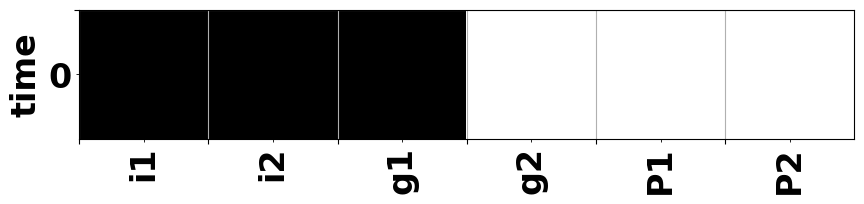

In [30]:
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
for i,attractor in enumerate(attractors): 
    #print attractor,list(attractors[attractor])
    if i==0: 
        visualize_unfolding(DCM,list(attractors2[attractor]),node_set=nodes,labels=True,fontsize=24,rotation=90,fontweight='bold',time_limit=10) 

(<Figure size 1000x1000 with 1 Axes>, <Axes: ylabel='time'>)

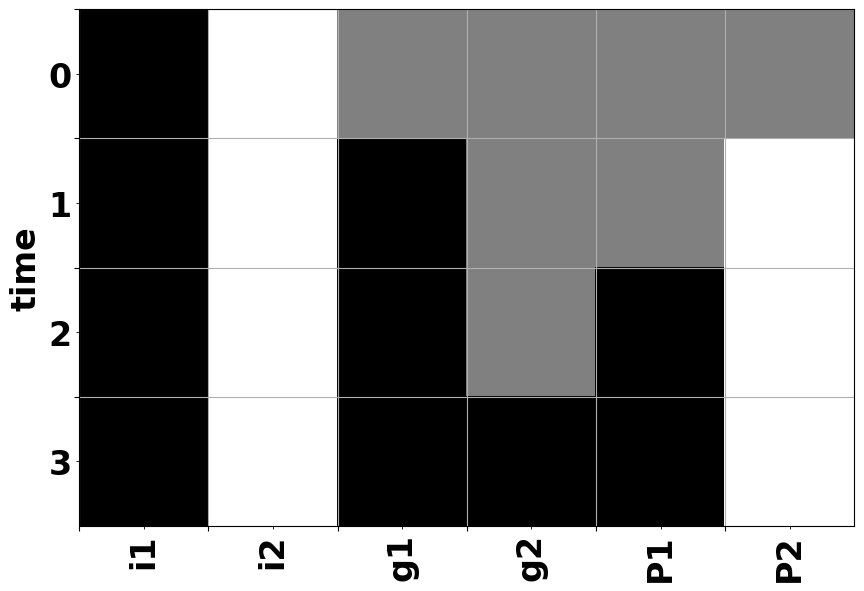

In [31]:
# Use some random test seeds
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
# test_seeds = ['var-0-out-1','var-1-out-0']
test_seeds = ['i1-1', 'i2-0']
visualize_unfolding(DCM,test_seeds,node_set=nodes,labels=True,fontsize=24,rotation=90,fontweight='bold',time_limit=10) 

In [32]:
unfolding=BFS_threshold(threshold_DCM,test_seeds,input_type='steady',time_limit=10,conversion=False)
unfolding

{0: {'F-T0', 'thr-0-var-5-out-0', 'var-0-out-1', 'var-1-out-0'},
 1: {'thr-2-var-4-out-1', 'var-2-out-1', 'var-5-out-0'},
 2: {'var-4-out-1'},
 3: {'var-3-out-1'}}

The visualize_unfolding() method does not necessarily show the actual states of each node that is part of the pathway module (i.e., does not indicate whether node is in ON/OFF state) in the DCM, but seems to be showing which nodes are activated (i.e., determined to be set to either ON/OFF) due to network dynamics. This can be confusing. -- **This has been resolved.**

Also, the unfolding is determined assuming default ***pinning*** perturbation. Specify *input_type = 'pulse'* to study pulse perturbations.



#### Functions required to find modules (including synergistic modules, maximal pathway modules etc.)  & estimate dynamical modularity.

In [43]:
#define s-units and modules; map any node set to numbers starting with 0
#NOTE: this function only works with fully Boolean graphs
def get_sunits(N):
    sunits,sunit_map=set([]),{}
    num=0
    for node in N.nodes:
        for state in ['0','1']:
            sunits.add(num)
            sunit_map[num]=node.name+'-'+state
            num+=1
        
    return sunits,sunit_map

# sunits,sunit_map=get_sunits(N)
# print(sunit_map)

In [44]:
units, map = get_sunits(N)
print(f"s-units: \n{units}\n")
print(f"s-unit map (a dictionary mapping s-unit indices to actual nodes in the DCM): \n{map}")

s-units: 
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

s-unit map (a dictionary mapping s-unit indices to actual nodes in the DCM): 
{0: 'i1-0', 1: 'i1-1', 2: 'i2-0', 3: 'i2-1', 4: 'g1-0', 5: 'g1-1', 6: 'g2-0', 7: 'g2-1', 8: 'P1-0', 9: 'P1-1', 10: 'P2-0', 11: 'P2-1'}


In [45]:
#list method that ensures that s-unit combinations are in the correct order
#order is based on node number and state, starting with 0
def to_list(seed,smap,translator=None):
    """ 
    Determine the sunits involved in the seed, based on the sunit_map. 
    This may take either a tuple of s-units, or a string of s-units (requires the translator argument).
    smap : maps individual node numbers to names, the translator maps seed strings to node numbers. 
    
    """
    
    ls = []
    if isinstance(seed,str): 
        seed = translator[seed] 
        
    for node in seed: 
        ls.append(smap[node]) 

    return ls 

# seed=(33,)
# print(seed,to_list(seed,sunit_map)) #seed is a tuple
# print(str(seed),to_list(str(seed),sunit_map,translator))

In [46]:
to_list(units, map)

['i1-0',
 'i1-1',
 'i2-0',
 'i2-1',
 'g1-0',
 'g1-1',
 'g2-0',
 'g2-1',
 'P1-0',
 'P1-1',
 'P2-0',
 'P2-1']

In [47]:
#retrieve variables from a list of sunits
import re
def get_variables(sunits):
    """
    Input: set of s-unit names -- node_name-node_state as retrieved from the sunit-map. E.g., i2-0, i2-1, g2-0, g2-1, etc.
    Output: actual node names. E.g., i1, i2, P1, P2, g1, g2, etc. 
    """
    
    #print sunits
    variables=set([])
    for sunit in sunits:
        match=re.search('-{1}[0-9]+$',sunit) #match based on -x where x is the state of the variable
        variables.add(sunit.replace(match.group(0),'')) #remove -x
        
    return variables

# sunit_set={sunit_map[sunit] for sunit in sunit_map}
# print get_variables(sunit_set)

In [48]:
sunit_set={map[sunit] for sunit in map}
print(sunit_set)
get_variables(sunit_set)

{'i2-0', 'P1-0', 'P1-1', 'i2-1', 'g1-1', 'P2-1', 'g2-0', 'i1-1', 'P2-0', 'g2-1', 'i1-0', 'g1-0'}


{'P1', 'P2', 'g1', 'g2', 'i1', 'i2'}

In [49]:
# #string method to sort a set of modules and display them by seed, length
# def module_to_string(modules,smap,translator=None,reduced=True,n=None,unfolding=False,tops=None,s=None):
#     """ displays the modules in sorted order, along with their length
#     assumes modules have already been reduced; otherwise, this will reduce them (network parameter required) """
    
#     if not reduced:
#         modules=module_reduce(modules,n)
    
#     total=0
#     for module in sorted(modules,key=lambda x: len(modules[x]), reverse=True):
#         if s and s!=len(to_list(module,smap,translator)): #compare seed size
#             continue
#         if tops and total>=tops: #only print out the top modules by length (for the given seed size)
#             break
#         print(to_list(module,smap=smap,translator=translator),len(modules[module]))
#         if unfolding: 
#             print(modules[module])
#         total+=1

# #rmodules=module_reduce(modules,DCM)
# #module_to_string(rmodules,sunit_map,translator)
# #module_to_string(modules,sunit_map,translator,reduced=False,n=DCM,tops=10,s=2)

In [50]:
#find all pathway modules per given seed size s
#NOTE: uses BFS_threshold for now, generic function solver later
def find_modules(N,s=1,sunits=None,sunit_map=None,modules={},translator={},pinning=True,seeds=None):
    """ 
    find ALL pathway modules for a given network N and seed size s, with the given modules and translator,
    can iteratively add to modules for different s values
    
    set pinning to True to make the assumption that once states are resolved, they never change,
    set seeds to a list of which seeds you want to find modules for (by s-unit number) 
    
    NOTE: Here, N is the original cana BooleanNetwork object, NOT the DCM / thresholded DCM representation.

    """
    
    # define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
        
    # define seeds -- can use sampling in case network is large and 's' is also high
    if not seeds:
        seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    

    for seed in seeds:
        modules[str(seed)] = set([])
        translator[str(seed)] = seed #map between the string and the actual seed numbers --- what is the point of this?!!!!

    # network, TODO: fix this to work with representations that can't be converted

    if True: # assume we can convert to DCM
        n=N.dynamics_canalization_map() #output=None 
        
    # other parameters
    if pinning:
        input_type='steady'
    else: 
        input_type='pulse'

    # iterate through given seeds
    for seed in seeds:
        units=to_list(seed,sunit_map) # this retrieves seed names as: i1-0, i1-1, g1-0, g1-1, etc.
        # quick check for contradiction
        vals=get_variables(units) # retrieve actual node names from list of DCM-nodes ('units') -- i1, i2, g1, g2, etc.
        if len(vals)<len(units): # we have multiple nodes sharing the same variable -- i1-1, i1-0 are both in the list of seeds -- contradiction
            continue
            
        unfolding=BFS_threshold(n,units,input_type=input_type,time_limit=1,conversion=True,name_conversion=True)

        # The following line can be used to remove non-variable nodes from the dynamic unfolding (e.g., threshold nodes, fusion nodes, etc.)
        # unfolding={t:{x for x in unfolding[t] if n.nodes[x]['type']=='variable'} for t in unfolding} # simplify

        modules[str(seed)]=unfolding # *********** why is the key a string? why do we require the 'translator'? ***********

    return modules,translator

#seeds=[name_to_index(['CIA-0'],sunit_map)] #individual seed
#seeds=names_to_index([['en-1'],['SLP-1']],sunit_map) #multiple seeds [['CIA-0'],['en-1','SMO-1'],['en-1']]
#modules,translator=find_modules(N,s=1,pinning=True,seeds=None) #None or seeds, s=1
#modules,translator=find_modules(N,5,sunits,sunit_map,modules,translator,pinning=True,seeds=None) #s=2 or higher
# module_to_string(modules,sunit_map,translator,reduced=False,n=DCM,unfolding=False,tops=10,s=4)

In [51]:
mod, trans = find_modules(N, s=2)
mod


{'(0, 1)': set(),
 '(0, 2)': {0: {'F-T0', 'thr-0-var-5-out-0', 'var-0-out-0', 'var-1-out-0'},
  1: {'var-2-out-0', 'var-5-out-0'},
  2: {'var-4-out-0'},
  3: {'var-3-out-0'}},
 '(0, 3)': {0: {'var-0-out-0', 'var-1-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'},
  3: {'F-T0', 'thr-0-var-5-out-0', 'var-3-out-0'},
  4: {'var-5-out-0'}},
 '(0, 4)': {0: {'var-0-out-0', 'var-2-out-0'},
  1: {'var-4-out-0'},
  2: {'F-T0', 'thr-0-var-5-out-0', 'var-3-out-0'},
  3: {'var-5-out-0'}},
 '(0, 5)': {0: {'var-0-out-0', 'var-2-out-1'}},
 '(0, 6)': {0: {'F-T0', 'thr-0-var-5-out-0', 'var-0-out-0', 'var-3-out-0'},
  1: {'var-2-out-0', 'var-5-out-0'},
  2: {'var-4-out-0'}},
 '(0, 7)': {0: {'var-0-out-0', 'var-3-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'}},
 '(0, 8)': {0: {'var-0-out-0', 'var-4-out-0'},
  1: {'F-T0', 'thr-0-var-5-out-0', 'var-2-out-0', 'var-3-out-0'},
  2: {'var-5-out-0'}},
 '(0, 9)': {0: {'var-0-out-0', 'var-4-out-1'},
  1: {'var-2-out-0', 'var-3-out-1'}},
 '(0, 10)': {0: {'v

In [52]:
print("Length of modules:")
[len(mod[t]) for t in mod]
# mod

Length of modules:


[0,
 4,
 5,
 4,
 1,
 3,
 3,
 3,
 2,
 4,
 3,
 4,
 2,
 4,
 1,
 3,
 2,
 3,
 2,
 4,
 3,
 0,
 3,
 4,
 2,
 2,
 2,
 2,
 1,
 3,
 4,
 1,
 2,
 3,
 3,
 3,
 1,
 3,
 0,
 2,
 2,
 3,
 2,
 3,
 3,
 3,
 1,
 3,
 2,
 3,
 3,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 0]

***Does find_top_modules() look at temporal subsumption?***

A pathway module is considered maximal if it cannot be **temporally** subsumed by any other pathway modules with the same seed set size. 

*find_top_modules()* sorts pathway modules by size (i.e., total *time* length of unfolding, NOT size of pathway module set), and then checks whether the **seeds** of the current pathway module are already present in any of the current list of "top pathway modules".  
- If no, this entails that the seed set of the current pathway module has not been encountered before, which implies that its unfolding must be unique -- so this pathway module is then added to the set of top modules.  
- If yes, then this entails that the unfolding due to this seed set is already present in the current pathway module -- so this seed set is ignored.  
- However, this fails to account for cases of logical obstruction, where - even if the seed set of a given pathway module (#1) might be present in another pathway module set (#2), the dynamical unfolding from this seed set (#1) may not necessarily be entirely replicated in the dynamical unfolding of pathway module #2 due to the possibility of logical obstruction. The current code does **not** account for this. 

The list of pathway modules contained within *nu*, the network unfolding dictionary, contains the pathway modules of all seed sets of size *s* (as specified in the *find_dynamic_modules()* method), so the list "top modules" returned by the *find_top_modules()* method **must** be a list of *maximal* pathway modules (**assuming that the manner in which the "seed set check" occurs accounts for temporal subsumption**).

**Parmer assumes that as long as the seed set of one pathway module is contained in another *pathway module set*, the unfolding of this pathway module is temporally subsumed by the other pathway module.**   

In [76]:
#function to find top modules given a set of modules
def find_top_modules(nu,tm,sizes,candidates,input_type='steady'):
    """ 
    nu -> network unfolding dictionary
       -> key   : seed set
       -> value : step-wise dynamic unfolding of the seed set
       
    candidates: translator dictionary that returns list of actual seed nodes from their string representation

    Determines the top modules by seeing which modules can be subsumed into other modules. 
    Specifically, it tests every candidate seed set to see if it is along the path of a larger module in nu (network unfolding dict), O(n**2) time complexity
    Candidates is a dictionary where the keys are (str) node names and the values are actual nodes to check 

    """
    
    pathway_modules_set = [] # to track which pathway module sets the candidate seed set might be found in 
    for seed in sorted(sizes,key=lambda x:sizes[x],reverse=True): # start with seed sets that produce the largest ('longest' might be more appropriate here) modules

        if seed in candidates: # only check our candidates 
            # isn't this redundant? since 'candidates' contains all seed sets as keys in the exact way it is defined in the find_dynamic_modules() method?
            
            subsumed=False
            for current_set in pathway_modules_set: # compare against nodes from all the pathway modules we've encountered before 
                # perform node-wise comparison
                # current_set: set of nodes visited in the current pathway module (corresponding to a given seed set)
                
                # ************** Does this comparison account for TEMPORAL subsumption? -- key for complex modules definition **************
                # 
                if not candidates[seed]-current_set: # -- look at SET OPERATIONS -- 
                    # the candidate seed set is a subset of one of the pathway module sets of a previous (longer) pathway module 
                    # this entails that the dynamical unfolding of this candidate seed set is contained within the current pathway module 
                    # ******** this "check" does not account for logical obstruction ********  
                    subsumed=True
                    break
            
            if not subsumed:
                # add to top_modules
                tm[seed]=nu[seed]
                # add the node's unfolding to pathway_modules_set
                if input_type=='steady':
                    # list of set (tuples) of all nodes visited in the CURRENT pathway module -- referred to as the 'pathway module set' in the Parmer paper
                    pathway_modules_set.append({x for t in nu[seed] for x in nu[seed][t]}) # t -> unfolding time step; x -> nodes visited at time step t

                else: #add a separate set for each time step -- ******** haven't understood the next two lines yet ********
                    for t in nu[seed]:
                        pathway_modules_set.append({x for x in nu[seed][t]}) # isn't this the EXACT same as the line of code in input_type=='steady'?!!                        
            
    return tm 

#n,t,si,c=find_dynamic_modules(DCM,input_type='steady',s=1,samples=None,tm=True)
#print len(t),len(n)
#for node in sorted(si,key=lambda x: s[x],reverse=True):
#    if node in t: pass #print node,si[node]#,t[node]

In [77]:
a = {0: {1,2,3,4}, 1: {2,3,4}, 2: {5,6,7}}
a

{0: {1, 2, 3, 4}, 1: {2, 3, 4}, 2: {5, 6, 7}}

In [78]:
a[1]-a[0] # removes elements of set 0 from set 1 and returns this 

set()

In [79]:
a[0]-a[1] # removes elements of set 1 from set 10 and returns this 

{1}

In [80]:
a[2]-a[1]

{5, 6, 7}

In [81]:
a[1]-a[2]

{2, 3, 4}

In [177]:
#function to find all dynamic modules of single seed perturbations
def find_dynamic_modules(n,s=1,input_type='steady',time_limit=1,conversion=True,samples=None,tm=True,seeds=None):
    
    """ 
    Test all possible seeds of a network to determine each seed's dynamic unfolding.

        -> n: DCM representation of a network
        -> If tm=True: combines any unfolding that is a subset of another unfolding and returns the largest unique unfoldings.
        -> input_type: may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step),
           or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps). 
        -> s: dictates how many nodes the seed should contain, i.e., size of seed set; the default is to only search for dynamic modules 
           with one starting node

    NOTE: This function does a combinatoric search over all possible seed configurations, be careful with memory constraints
    when running with large # of nodes.

        -> If samples=x, then this will draw x samples from the possible combinations with replacement
        -> If tm=True, this will try to compute all top modules
        -> If seeds is not None, this will find all dynamic modules from the seeds contained in that iterable (must be hashable);
        -> Note that seeds takes precedence over samples
    
    *** Converts the network n to a thresholded representation ***
    
    """
    
    # perform network conversion now itself since we want to store variable nodes in a list immediately
    # instead, set conversion=False in the BFS_threshold function call since already converted.
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    network_unfolding, sizes = {}, {}

    # remove all non-variable nodes for cleaner visibility and comparison
    nodes=[x for x in n if n.nodes[x]['type']=='variable']
    # here, by using node names from the converted threshold DCM, node names are already guaranteed to be of the updated CANA DCM naming convention, e.g, var-0-out-0, var-0-out-1, etc. 
    # name conversion inside BFS is not required

    # if seeds are not specified, either find all combinations of seeds of size s, or sample from possible combinations
    if not seeds:
        if samples: #sampling to avoid memory issues with high combinations
            # seeds=[[random.choice(nodes) for j in range(s)] for i in range(samples)] # this gives samples with replacement -- might produce duplicates
            # let's generate samples without duplicates 
            seeds = [random.sample(nodes, s) for _ in range(samples)] # this generates 's' sized samples without replacement -- may lead to errors if s > # of nodes in the network
            
            # NOTE: there may still be contradictions within each seed sample -- i1-0 & i1-1 may be in the same seed group -- however, this is resolved within the BFS_threshold() method

        else: # get all possible combinations
            seeds=combinations(nodes,s)

    #elif s>1:
    #    #find combinations of our starting seeds; may need to be explicitly passed 
    #    seeds=combinations(seeds,s)
    candidates={} #used for top modules later

    for seed in seeds:
        # retreive one seed set at a time
        seed=list(seed) # typecast to list
        
        # quick check for contradiction
        vals=[n.nodes[x]['variable'] for x in seed] # retrieve variable names: i1, i2, etc.
        if len(set(vals))<len(vals): 
            # we have multiple nodes sharing the same variable, e.g., i1-0 and i1-1 are both in the seed -- not allowed
            continue
        
        unfolding = BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=not conversion, name_conversion= not conversion)        

        # the next line of code does the same job as the module_reduce() method
        unfolding = {t:{x for x in unfolding[t] if n.nodes[x]['type']=='variable'} for t in unfolding} # simplify by removing all non-variable nodes from the unfolding
        
        #if s==1: 
        #    seed=seed[0] #special case for single nodes, allows us to find top modules
        
        # create dictionary where key=seed, value=unfolding
        network_unfolding[str(seed)] = unfolding # Again, why typecast to string??!!!
        sizes[str(seed)] = sum([len(unfolding[t]) for t in unfolding])
        
        # update candidates
        candidates[str(seed)]=set(seed) # translator dictionary that returns list of actual seed nodes from their string representation

 
    # condense down to the top modules by finding which modules are subsets of other modules (only consider variable type nodes)
    # NOTE: if a node is turned on at any point, it is guaranteed to follow the trajectory specified by its own module
    # a node along the path of another module can therefore have its trajectory be subsumed into that module
    top_modules={}
    if tm:
        top_modules=find_top_modules(network_unfolding,top_modules,sizes,candidates,input_type=input_type)
           
    return network_unfolding,top_modules,sizes,candidates

#nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',s=1,samples=None,tm=True,seeds=[['CIA-0'],['en-1','SMO-1'],['en-1']])
#nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',s=1,samples=None,tm=True,seeds=None)
#print tm

In [83]:
network_unfolding,top_modules,sizes,candidates = find_dynamic_modules(DCM, input_type='steady', s=2, samples=None, tm=True, seeds=None)

In [84]:
network_unfolding

{"['var-0-out-0', 'var-1-out-0']": {0: {'var-0-out-0', 'var-1-out-0'},
  1: {'var-2-out-0', 'var-5-out-0'},
  2: {'var-4-out-0'},
  3: {'var-3-out-0'}},
 "['var-0-out-0', 'var-1-out-1']": {0: {'var-0-out-0', 'var-1-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'},
  3: {'var-3-out-0'},
  4: {'var-5-out-0'}},
 "['var-0-out-0', 'var-2-out-0']": {0: {'var-0-out-0', 'var-2-out-0'},
  1: {'var-4-out-0'},
  2: {'var-3-out-0'},
  3: {'var-5-out-0'}},
 "['var-0-out-0', 'var-2-out-1']": {0: {'var-0-out-0', 'var-2-out-1'}},
 "['var-0-out-0', 'var-3-out-0']": {0: {'var-0-out-0', 'var-3-out-0'},
  1: {'var-2-out-0', 'var-5-out-0'},
  2: {'var-4-out-0'}},
 "['var-0-out-0', 'var-3-out-1']": {0: {'var-0-out-0', 'var-3-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'}},
 "['var-0-out-0', 'var-4-out-0']": {0: {'var-0-out-0', 'var-4-out-0'},
  1: {'var-2-out-0', 'var-3-out-0'},
  2: {'var-5-out-0'}},
 "['var-0-out-0', 'var-4-out-1']": {0: {'var-0-out-0', 'var-4-out-1'},
  1: {'var-2-out-0', 'var-3-

In [85]:
sizes

{"['var-0-out-0', 'var-1-out-0']": 6,
 "['var-0-out-0', 'var-1-out-1']": 6,
 "['var-0-out-0', 'var-2-out-0']": 5,
 "['var-0-out-0', 'var-2-out-1']": 2,
 "['var-0-out-0', 'var-3-out-0']": 5,
 "['var-0-out-0', 'var-3-out-1']": 4,
 "['var-0-out-0', 'var-4-out-0']": 5,
 "['var-0-out-0', 'var-4-out-1']": 4,
 "['var-0-out-0', 'var-5-out-1']": 5,
 "['var-0-out-0', 'var-5-out-0']": 5,
 "['var-0-out-1', 'var-1-out-0']": 6,
 "['var-0-out-1', 'var-1-out-1']": 3,
 "['var-0-out-1', 'var-2-out-0']": 5,
 "['var-0-out-1', 'var-2-out-1']": 2,
 "['var-0-out-1', 'var-3-out-0']": 5,
 "['var-0-out-1', 'var-3-out-1']": 3,
 "['var-0-out-1', 'var-4-out-0']": 5,
 "['var-0-out-1', 'var-4-out-1']": 4,
 "['var-0-out-1', 'var-5-out-1']": 5,
 "['var-0-out-1', 'var-5-out-0']": 5,
 "['var-1-out-0', 'var-2-out-0']": 5,
 "['var-1-out-0', 'var-2-out-1']": 5,
 "['var-1-out-0', 'var-3-out-0']": 3,
 "['var-1-out-0', 'var-3-out-1']": 3,
 "['var-1-out-0', 'var-4-out-0']": 4,
 "['var-1-out-0', 'var-4-out-1']": 4,
 "['var-1-ou

In [86]:
candidates

{"['var-0-out-0', 'var-1-out-0']": {'var-0-out-0', 'var-1-out-0'},
 "['var-0-out-0', 'var-1-out-1']": {'var-0-out-0', 'var-1-out-1'},
 "['var-0-out-0', 'var-2-out-0']": {'var-0-out-0', 'var-2-out-0'},
 "['var-0-out-0', 'var-2-out-1']": {'var-0-out-0', 'var-2-out-1'},
 "['var-0-out-0', 'var-3-out-0']": {'var-0-out-0', 'var-3-out-0'},
 "['var-0-out-0', 'var-3-out-1']": {'var-0-out-0', 'var-3-out-1'},
 "['var-0-out-0', 'var-4-out-0']": {'var-0-out-0', 'var-4-out-0'},
 "['var-0-out-0', 'var-4-out-1']": {'var-0-out-0', 'var-4-out-1'},
 "['var-0-out-0', 'var-5-out-1']": {'var-0-out-0', 'var-5-out-1'},
 "['var-0-out-0', 'var-5-out-0']": {'var-0-out-0', 'var-5-out-0'},
 "['var-0-out-1', 'var-1-out-0']": {'var-0-out-1', 'var-1-out-0'},
 "['var-0-out-1', 'var-1-out-1']": {'var-0-out-1', 'var-1-out-1'},
 "['var-0-out-1', 'var-2-out-0']": {'var-0-out-1', 'var-2-out-0'},
 "['var-0-out-1', 'var-2-out-1']": {'var-0-out-1', 'var-2-out-1'},
 "['var-0-out-1', 'var-3-out-0']": {'var-0-out-1', 'var-3-out-

In [87]:
top_modules

{"['var-0-out-0', 'var-1-out-0']": {0: {'var-0-out-0', 'var-1-out-0'},
  1: {'var-2-out-0', 'var-5-out-0'},
  2: {'var-4-out-0'},
  3: {'var-3-out-0'}},
 "['var-0-out-0', 'var-1-out-1']": {0: {'var-0-out-0', 'var-1-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'},
  3: {'var-3-out-0'},
  4: {'var-5-out-0'}},
 "['var-0-out-1', 'var-1-out-0']": {0: {'var-0-out-1', 'var-1-out-0'},
  1: {'var-2-out-1', 'var-5-out-0'},
  2: {'var-4-out-1'},
  3: {'var-3-out-1'}},
 "['var-0-out-0', 'var-5-out-1']": {0: {'var-0-out-0', 'var-5-out-1'},
  1: {'var-2-out-0', 'var-4-out-0'},
  2: {'var-3-out-0'}},
 "['var-0-out-1', 'var-2-out-0']": {0: {'var-0-out-1', 'var-2-out-0'},
  1: {'var-4-out-0'},
  2: {'var-3-out-0'},
  3: {'var-5-out-0'}},
 "['var-0-out-1', 'var-5-out-1']": {0: {'var-0-out-1', 'var-5-out-1'},
  1: {'var-2-out-1', 'var-4-out-0'},
  2: {'var-3-out-0'}},
 "['var-0-out-0', 'var-3-out-1']": {0: {'var-0-out-0', 'var-3-out-1'},
  1: {'var-2-out-0'},
  2: {'var-4-out-0'}},
 "['var-0-out-0', 

In [88]:
len(network_unfolding)

60

In [89]:
len(top_modules)

14

In [67]:
# WRTIE THIS LATER IF REQUIRED
# def convert_to_original_names(modules, candidates, threshold_DCM):

In [90]:
def module_reduce(modules,n):
    """ 
    This method simplifies the dynamical unfolding of each seed set in 'modules' by removing all non-variable nodes (such as fusion nodes, threshold nodes) 

    n -> DCM / threholded graph object
    
    """
    module_set={}
    for seed in modules:
        unfolding=modules[seed] # retrieve unfolding for each seed set
        module_set[seed]=[x for t in unfolding for x in unfolding[t] if x in n and n.nodes[x]['type']=='variable'] # retrieve only 'variable' type nodes from the unfolding (ignore threshold / fusion nodes)
        
    return module_set
   
# module_reduce(modules,DCM) #works with a DCM or a thresholded graph, to see the seed: to_list(module,sunit_map,translator)

In [91]:
module_reduce(network_unfolding, threshold_DCM)

{"['var-0-out-0', 'var-1-out-0']": ['var-1-out-0',
  'var-0-out-0',
  'var-2-out-0',
  'var-5-out-0',
  'var-4-out-0',
  'var-3-out-0'],
 "['var-0-out-0', 'var-1-out-1']": ['var-1-out-1',
  'var-0-out-0',
  'var-2-out-0',
  'var-4-out-0',
  'var-3-out-0',
  'var-5-out-0'],
 "['var-0-out-0', 'var-2-out-0']": ['var-2-out-0',
  'var-0-out-0',
  'var-4-out-0',
  'var-3-out-0',
  'var-5-out-0'],
 "['var-0-out-0', 'var-2-out-1']": ['var-2-out-1', 'var-0-out-0'],
 "['var-0-out-0', 'var-3-out-0']": ['var-3-out-0',
  'var-0-out-0',
  'var-2-out-0',
  'var-5-out-0',
  'var-4-out-0'],
 "['var-0-out-0', 'var-3-out-1']": ['var-3-out-1',
  'var-0-out-0',
  'var-2-out-0',
  'var-4-out-0'],
 "['var-0-out-0', 'var-4-out-0']": ['var-4-out-0',
  'var-0-out-0',
  'var-2-out-0',
  'var-3-out-0',
  'var-5-out-0'],
 "['var-0-out-0', 'var-4-out-1']": ['var-4-out-1',
  'var-0-out-0',
  'var-2-out-0',
  'var-3-out-1'],
 "['var-0-out-0', 'var-5-out-1']": ['var-5-out-1',
  'var-0-out-0',
  'var-2-out-0',
  'var-4

- find_info_modules() : does exactly the same thing as find_dynamical_modules() -- redundant?!  
- info_modules() : combines top_modules() with syn_modules() to return complex modules (?)
- DCM_coverage() & DCM_coverage_greedy() : finds covers of a DCM based on given set of modules -- check differences in the two algorithm implementations 
- dynamical_modularity(): returns the independence scores of modules from a given cover
- test_cover_independence(): returns independence scores of a single cover for each module within the cover 



***Better option is to backtrack the methods required, beginning with calculation of dynamical modularity based on a cover of the DCM, and then figuring out which methods are required to implement this function.***

**Any cover-finding-method needs to look for synergy within seed sets of maximal modules first, to find complex modules. Once complex modules are found, then a suitable cover may be estimaed.**  

### **Complex Modules**

In [176]:
from itertools import combinations
from collections import defaultdict

def _pathway_set_from_unfolding(unfolding, graph=None, input_type='steady', variable_only=True):
    """
    Return the pathway module set S = ⋃_t S^t. 
    If graph is provided and variable_only=True, keep only nodes with graph.nodes[x]['type']=='variable'.
    """
    if input_type == 'steady':
        # union of all nodes that ever fire
        S = set().union(*[set(unfolding[t]) for t in unfolding]) if unfolding else set()
    else:
        # pulse or other: still use union over time for S
        S = set().union(*[set(unfolding[t]) for t in unfolding]) if unfolding else set() 
        
    if graph is not None and variable_only:
        S = {x for x in S if graph.nodes.get(x, {}).get('type') == 'variable'}

    return S

def _canonical_seed_key(seed_nodes):
    """
    Make a stable string key for a seed set (order independent).
    """
    return "|".join(sorted(seed_nodes))

def _ensure_unfolding_for_seed(seed_nodes, nu, threshold_graph, input_type='steady', time_limit=1):
    """
    Fetch unfolding from nu if present, otherwise compute via BFS_threshold.
    """
    key = str(tuple(sorted(seed_nodes))) 

    if key in nu:
        return nu[key]
 
    # Fallback: compute
    return BFS_threshold(threshold_graph, list(seed_nodes), input_type=input_type, time_limit=time_limit, conversion=True, name_conversion=False)



In [126]:
def find_complex_modules(
    nu,                 # dict: seed-string -> unfolding {t: [nodes]}
    candidates,         # dict: seed-string -> set(nodes)  (actual node names as used in threshold_DCM)
    threshold_graph,    # the threshold DCM produced by create_threshold_network(DCM)
    s,                  # seed size for which nu was primarily generated
    input_type='steady',
    time_limit=1,
    variable_only=True,
    allow_on_the_fly=True
):
    """
    Return dict of complex modules for seed size s:
      key: canonical seed-key (sorted node names joined by '|')
      value: {
          'seeds': frozenset(seed nodes),
          'unfolding': {t: [nodes]},
          'S': set of s-units (variable nodes only if variable_only=True),
          'length': max time index in unfolding (T),
          'size': |S|
      }

    Logic:
      1) Build pathway-set S for every module (union over time; variable-only if requested).
      2) Keep only 'maximal' modules at seed size s (no S subset of any module with seed size <= s).
      3) For each maximal candidate with |seeds|=s, check synergy for all proper non-empty seed splits A|B:
           S_AB  = μ(A∪B)
           S_A   = μ(A)
           S_B   = μ(B)
           require S_AB ⊃ (S_A ∪ S_B) for all A (otherwise reject).
         If any split yields S_AB ⊂ (S_A ∪ S_B), that's logical obstruction ⇒ reject.
    """
    # 1) Precompute S-sets and basic stats for everything in nu
    modules_info = {}
    by_seedsize   = defaultdict(list)

    for k, unfolding in nu.items():
        # recover actual seed set from candidates (nu keys may be stringified tuples/lists)
        seed_nodes = candidates.get(k, None)
        if seed_nodes is None:
            # try to parse the key into something that appears in candidates
            # fallbacks: some notebooks use str(list) / str(tuple) as keys
            # try all candidate keys with identical sets
            parsed = None
            try:
                maybe = eval(k)
                if isinstance(maybe, (list, tuple, set)):
                    parsed = set(maybe)
            except Exception:
                parsed = None
            if parsed is not None:
                # find a candidates entry that matches this set
                for ck, cset in candidates.items():
                    if set(cset) == set(parsed):
                        seed_nodes = set(cset)
                        break
        if seed_nodes is None:
            # As a last resort, try to parse from unfolding's t=0 if present and looks like seed echo
            seed_nodes = set()

        S = _pathway_set_from_unfolding(unfolding, graph=threshold_graph, input_type=input_type, variable_only=variable_only)
        length = max(unfolding.keys()) if unfolding else 0
        size   = len(S)
        canon  = _canonical_seed_key(seed_nodes)
        modules_info[canon] = {
            'seeds': frozenset(seed_nodes),
            'unfolding': unfolding,
            'S': S,
            'length': length,
            'size': size,
            'seed_size': len(seed_nodes),
            'raw_key': k
        }
        by_seedsize[len(seed_nodes)].append(canon)

    # 2) Maximality filter at seed size s 
    # A module at seed size s is maximal if its S-set is not a subset of any other module with 
    # seed size ≤ s (this captures temporal subsumption under pinning semantics).
    # Keep only those modules with |seeds| == s that are not subset of any module with seed size <= s (including s)
    seed_s_candidates = [canon for canon in by_seedsize.get(s, [])]
    maximal_candidates = []
    for ci in seed_s_candidates:
        Si = modules_info[ci]['S']
        subsumed = False
        # compare against all modules with seed size <= s (including other s)
        for other_size in [k for k in by_seedsize.keys() if k <= s]:
            for cj in by_seedsize[other_size]:
                if cj == ci: 
                    continue                
                Sj = modules_info[cj]['S']
                if Si <= Sj and (len(Sj) > len(Si) or modules_info[cj]['seed_size'] < modules_info[ci]['seed_size']):
                    subsumed = True
                    break
            if subsumed: 
                break
        if not subsumed:
            maximal_candidates.append(ci)

    # 3) Synergy check for each maximal candidate (all proper non-empty subsets A of the seed set)
    complex_modules = {}

    for ci in maximal_candidates:
        seeds_full = set(modules_info[ci]['seeds'])
        S_full     = modules_info[ci]['S']
        ok = True

        # Generate all non-empty proper subsets
        all_subsets = []
        for r in range(1, len(seeds_full)):  # 1...s-1
            for A in combinations(seeds_full, r):
                A = frozenset(A)
                B = frozenset(seeds_full - A)
                all_subsets.append((A, B))

        for A, B in all_subsets:
            # Get unfoldings (from nu if available; compute if needed)
            # A
            keyA = _canonical_seed_key(A)
            if keyA in modules_info:
                S_A = modules_info[keyA]['S']
            else:
                if not allow_on_the_fly:
                    ok = False; break
                unfolding_A = _ensure_unfolding_for_seed(A, nu, threshold_graph, input_type=input_type, time_limit=time_limit)
                S_A = _pathway_set_from_unfolding(unfolding_A, graph=threshold_graph, input_type=input_type, variable_only=variable_only)

            # B
            keyB = _canonical_seed_key(B)
            if keyB in modules_info:
                S_B = modules_info[keyB]['S']
            else:
                if not allow_on_the_fly:
                    ok = False; break
                unfolding_B = _ensure_unfolding_for_seed(B, nu, threshold_graph, input_type=input_type, time_limit=time_limit)
                S_B = _pathway_set_from_unfolding(unfolding_B, graph=threshold_graph, input_type=input_type, variable_only=variable_only)

            # AB (the full candidate) — this is S_full, but recompute if needed for robustness
            # (use existing S_full to avoid recomputation)
            S_union = S_A | S_B 

            # this takes care of any logical obstruction which may be present in S_union since we are doing a 
            # node-wise comparison below. Only if S_full contains all nodes in S_union AND more, we say there is 
            # synergy. 
            if not (S_full > S_union):  # strict superset = synergy
                # If it is a strict subset, that's logical obstruction; either way, fail complexity
                ok = False
                break

        if ok:
            complex_modules[ci] = {
                'seeds'     : modules_info[ci]['seeds'],
                'unfolding' : modules_info[ci]['unfolding'],
                'S'         : modules_info[ci]['S'],
                'length'    : modules_info[ci]['length'],
                'size'      : modules_info[ci]['size'],
                'seed_size' : modules_info[ci]['seed_size']
            }

    return complex_modules


In [194]:
cm = find_complex_modules(network_unfolding, candidates, threshold_DCM, s=2, time_limit=10)

In [195]:
len(cm)

4

In [196]:
for key in cm:
    print("\n************************\n")
    print(f"Seeds: {cm[key]["seeds"]}")
    print(f"\nPathway set: {cm[key]["S"]}")
    print(f"\nSize: {cm[key]["size"]}")
    print(f"\nUnfolding length: {cm[key]["length"]}")



************************

Seeds: frozenset({'var-0-out-1', 'var-1-out-0'})

Pathway set: {'var-4-out-1', 'var-5-out-0', 'var-3-out-1', 'var-0-out-1', 'var-1-out-0', 'var-2-out-1'}

Size: 6

Unfolding length: 3

************************

Seeds: frozenset({'var-0-out-1', 'var-3-out-0'})

Pathway set: {'var-4-out-1', 'var-5-out-0', 'var-0-out-1', 'var-3-out-0', 'var-2-out-1'}

Size: 5

Unfolding length: 2

************************

Seeds: frozenset({'var-1-out-1', 'var-3-out-1'})

Pathway set: {'var-1-out-1', 'var-3-out-1', 'var-4-out-0', 'var-5-out-1'}

Size: 4

Unfolding length: 2

************************

Seeds: frozenset({'var-1-out-1', 'var-4-out-1'})

Pathway set: {'var-1-out-1', 'var-3-out-1', 'var-4-out-1', 'var-5-out-1'}

Size: 4

Unfolding length: 2


***The find_complex_modules() method does not work for the in-built cell collective networks (e.g., Drosiphila, etc). There seems to be an issue with the naming conventions of the DCM. Check the BFS_threshold() method and try to resolve this.***